线性回归linear regression训练模型

In [1]:
from matplotlib import pyplot as plt
import random
import torch

人造数据集$y = Xw + b + \eta$，通过这个线性函数生成一组真实的数据分布，其中$w$是加权求和的系数列矩阵，$X$是一个含有真实的特征值的矩阵，行数代表样本数量，列数代表属性数量（和$w$的行数匹配），$b$是偏置值，$\eta$是加入的噪声，让生成的数据更真实更随机一点；这样生成一个数据集

In [2]:
'''
写一个函数生成一个线性回归的数据集
输入是w,b,以及样本数量
输出是特征矩阵X和真实值y(一般叫labels)
'''
def synthetic_data(w,b,num_examples):
    X = torch.normal(0,1,(num_examples,len(w)))#行数为样本数，列数为w的行数的矩阵
    y = torch.matmul(X,w) + b#做X矩阵（二维张量）和w向量（一维张量）的乘法，然后加上b，这里根据tensor的运算特性，b虽然只是一个值，但是会加到算出的一维张量的每一个元素上
    y += torch.normal(0,0.01,y.shape)#加上噪声
    return X,y.reshape((-1,1))#把y重新变成列向量，这里是二维张量，多行一列

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)
features[0], labels[0]

(tensor([-0.7144, -0.2061]), tensor([3.4448]))

labels是值真实值，features是指特征，也就是我们预估的可能会产生影响的属性；两者配对起来就是 ‘数据集’ 了

画个散点图看看效果：以feature的第二列的数据为自变量，labels的值为因变量画图；可以看出大致是个线性的

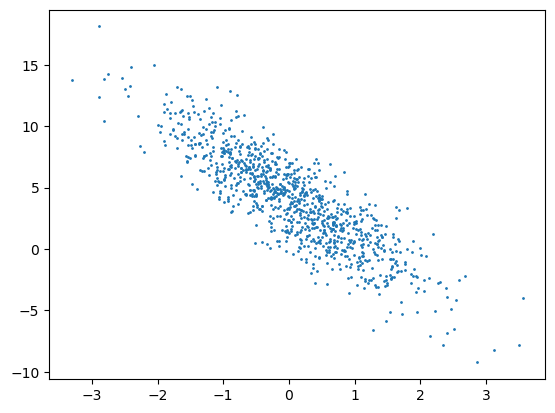

In [3]:
plt.scatter(features[:,1].detach().numpy(),
labels.detach().numpy(),1)

现在做小批量梯度下降（为什么不用直接全部1000个数据求出来的梯度来修正：因为小批量梯度下降，i有更好的泛性质；ii比之全部梯度下降更不容易进入局部最优解和鞍点中；iii迭代一次要的算力少）

写一个生成器函数：（这样可以不花大量的内存存储数据）
输入是小批量每一批的量（batch_size），特征矩阵（features），真实值（lebals）
输出每一次迭代的结果，用一次迭代一次（也可以作为迭代对象被for循环读取）

In [4]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)#乱序读取，因为小批量每次要保证是‘随机’取小批量个
    for i in range(0 ,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,1000)])
        yield features[batch_indices],labels[batch_indices]

batch_size = 10

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-7.5969e-01, -9.6882e-01],
        [ 1.6090e+00,  5.5684e-01],
        [ 3.9565e-01,  6.4681e-01],
        [-1.0813e+00, -1.8644e-01],
        [-1.7836e+00, -2.2716e+00],
        [-8.7602e-01,  1.0439e+00],
        [ 1.3732e+00,  2.9116e-01],
        [ 1.0327e-02, -9.8207e-04],
        [ 4.8992e-01, -4.6902e-01],
        [-9.2308e-01,  3.1258e+00]]) 
 tensor([[ 5.9864],
        [ 5.5392],
        [ 2.8075],
        [ 2.6693],
        [ 8.3627],
        [-1.0978],
        [ 5.9601],
        [ 4.2235],
        [ 6.7730],
        [-8.2606]])


定义模型初始化参数（也就是迭代起点，因为我们的最终目标是找到合格的w，b\{统称为参数\}）：w要随机生成，b可以置0，且它俩要求跟随该张量的梯度进行自动求导（requires_grad=True），用于后续的反向传播更新

In [5]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

定义线性回归模型

In [6]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

定义损失函数（注意这里生成的是一个张量，还没有对元素分量求和）

In [7]:
def squared_loss(y_hat,y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

定义优化算法

In [8]:
def sgd(params,lr,batch_size):#params就是（w，b）全部参数的意思，lr是学习率
    with torch.no_grad():
        for param in params:#对每个参数进行梯度反方向的更新
            param -= lr*param.grad / batch_size#对这批量的数据的损失函数求平均放在这个操作放在这里是一样的
            param.grad.zero_()#梯度不会自己删除，要重新置零

训练过程

In [9]:
lr = 0.03#设置合适的学习率
num_epochs = 3#进行三轮
net = linreg#调用线性回归模型学习
loss = squared_loss#调用这个损失函数

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):#对于每批次的数据
        l = loss(net(X,w,b),y)#计算损失
        l.sum().backward()#刚刚说了现在还是tensor，对各个分量求和（sum）然后反向传播求梯度（backwards）
        sgd([w,b],lr,batch_size)#调用优化算法来优化参数进行学习
    with torch.no_grad():#展示这一轮的学习结果，这个展示过程不要纳入计算图计算梯度
        train_1 = loss(net(features,w,b),labels)
        print(train_1.sum()/1000,'\n')

tensor(0.0523) 

tensor(0.0002) 

tensor(5.4597e-05) 

